In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statistics import *
import heartpy as hp
import copy
pd.options.display.max_rows = 450

# %load_ext autoreload
# %autoreload 2
import pwv


# Preprocessing

In [3]:
waveformData, segmentIndices = pwv.preprocess("/home/anrath/projects/research/josie/PWV/full_demo/Raw Data")

/home/anrath/miniconda3/envs/biopeaks/lib/python3.7/site-packages/numpy/ma/core.py:5240: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/anrath/miniconda3/envs/biopeaks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


## Filtering Waveforms

### Raw Waveforms

Text(0.5, 1.0, 'Pulse Wave Signal: Patient 0')

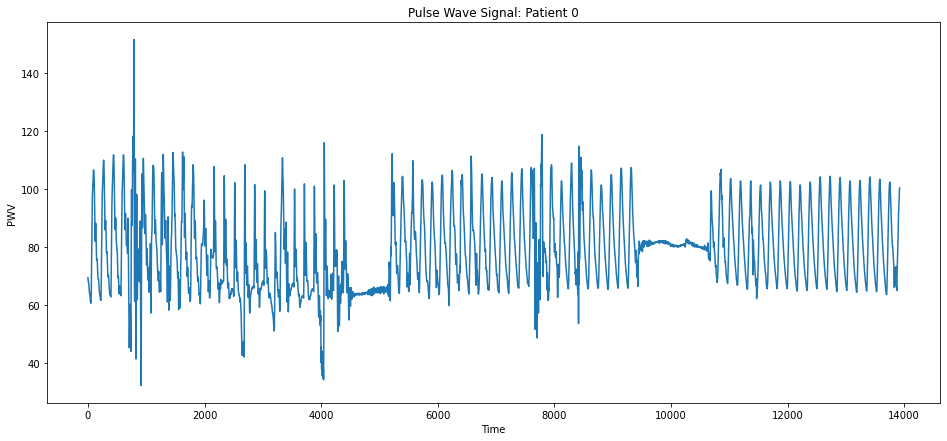

In [57]:
sample_rate=240.0
bpmin=0
bpmax=550

data = hp.get_data("/home/anrath/projects/research/josie/PWV/full_demo/Raw Data/X001.txt", delim = ' ', column_name = 'AO')
data = np.array([bpmin if i <= bpmin else (bpmax if i > bpmax else i) for i in data])
wd, m = hp.process(hrdata=data, sample_rate=sample_rate, bpmmin=bpmin, bpmmax=bpmax)

plt.figure(figsize=(16,7))
plt.plot(wd['hr'])
plt.xlabel("Time")
plt.ylabel("PWV")
plt.title("Pulse Wave Signal: Patient 0")

We can filter the waveform using highpass and lowpass Butterworth filters to get a smoother wave.

Text(0.5, 1.0, 'Pulse Wave Signal: Patient 0')

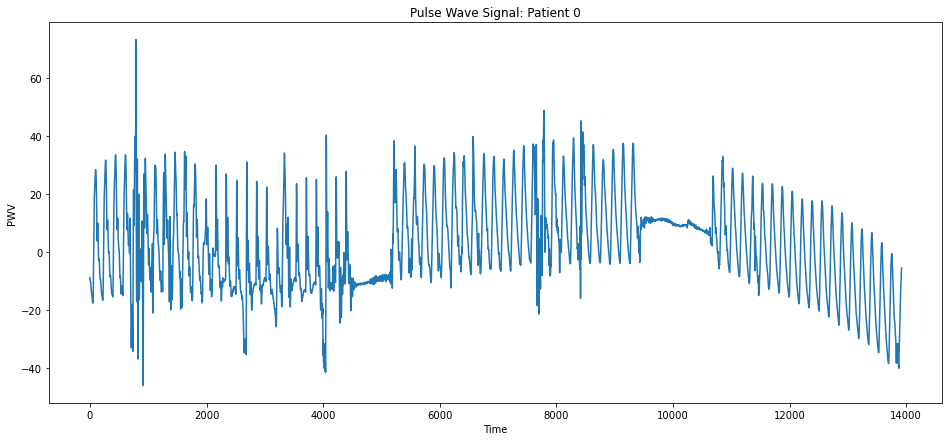

In [56]:
data = hp.filter_signal(data, cutoff=15, sample_rate=sample_rate, order=4, filtertype='lowpass')
data = hp.filter_signal(data, cutoff=.01, sample_rate=sample_rate, order=4, filtertype='highpass') # Does weird stuff imo
wd, m = hp.process(hrdata=data, sample_rate=sample_rate, bpmmin=bpmin, bpmmax=bpmax)

plt.figure(figsize=(16,7))
plt.plot(wd['hr'])
plt.xlabel("Time")
plt.ylabel("PWV")
plt.title("Pulse Wave Signal: Patient 0")

## Segmentation of Waveforms
Below is the filtered waveform for patient 0. We will examine the first 4000 values.

Text(0.5, 1.0, 'Pulse Wave Signal: Patient 0')

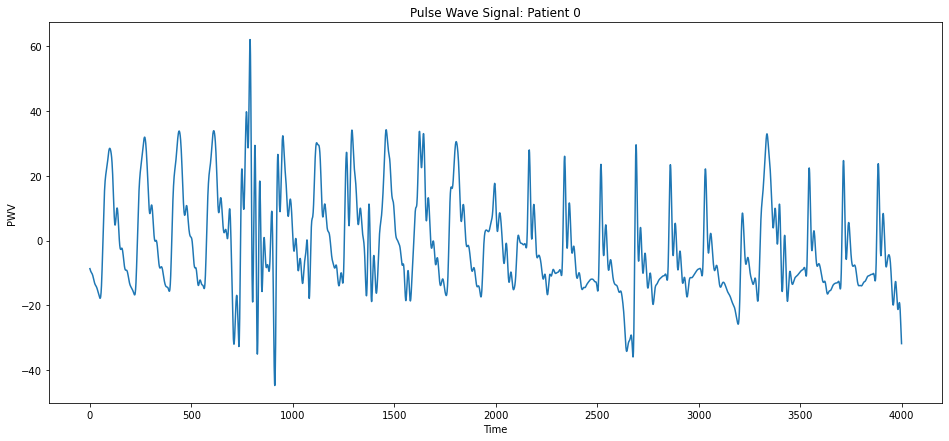

In [20]:
plt.figure(figsize=(16,7))
plt.plot(waveformData[0][0:4000])
plt.xlabel("Time")
plt.ylabel("PWV")
plt.title("Pulse Wave Signal: Patient 0")

We can segment this waveform into each individual pulsewave.

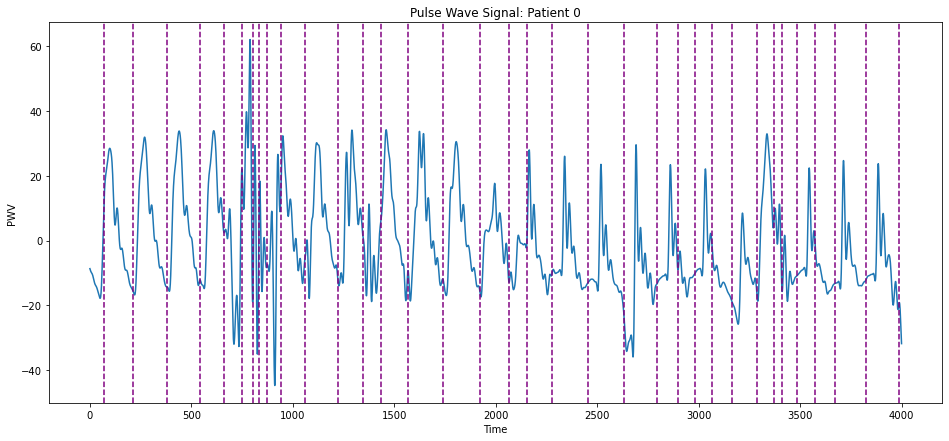

In [24]:
plt.figure(figsize=(16,7))
plt.plot(waveformData[0][0:4000])
plt.xlabel("Time")
plt.ylabel("PWV")
plt.title("Pulse Wave Signal: Patient 0")
for xc in segmentIndices[0]:
    if(xc>4000):
        break
    plt.axvline(x=xc, color='purple', linestyle="--")

# Metric Calculation

In [3]:
metrics = pwv.analyzeWave(waveformData, segmentIndices)

In [4]:
metrics

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,747.998575,21.918097,635.624806,29.0,1.148321,111.0,127.463590,20.550461,-0.102903,...,27.0,13.777321,15.246263,16.613899,-4.155877,-0.238027,84.0,-4.615922,0.399752,15.246263
1,0.0,701.998853,7.320904,439.254237,60.0,2.541872,109.0,277.064082,11.509835,0.274181,...,26.0,10.190231,0.523467,-3.665465,-8.444497,-0.273185,83.0,-3.295512,2.631441,0.523467
2,0.0,949.189534,8.463085,507.785083,60.0,4.403736,103.0,453.584819,12.720590,0.252294,...,28.0,11.047247,1.924021,-2.333485,-6.392833,-0.267320,75.0,-2.107227,2.927924,1.924021
3,0.0,1216.819768,5.886691,388.521635,66.0,15.882006,52.0,825.864297,10.719323,0.228446,...,26.0,9.765303,-2.502147,-7.334779,2.660535,-0.244448,26.0,8.777238,4.431989,-2.502147
4,0.0,1427.943680,28.622406,1173.518659,41.0,17.908548,15.0,268.628224,26.538937,-0.714018,...,14.0,34.640551,40.742140,42.825610,32.111752,3.291441,1.0,-17.494644,3.291441,40.742140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4620,21.0,-411.238205,-2.173292,-108.664619,50.0,-8.308909,37.0,-307.429624,-3.687817,-0.318344,...,17.0,-12.998339,-8.543855,-7.029330,-13.164946,1.431440,20.0,-8.450525,28.628799,-8.543855
4621,21.0,589.922830,16.671782,366.779208,22.0,7.465914,33.0,246.375174,18.488803,0.607362,...,6.0,-0.487124,-7.149535,-8.966556,-18.172424,-1.702479,27.0,3.535848,2.902957,-7.149535
4622,21.0,183.178141,0.663989,10.623829,16.0,4.101342,43.0,176.357710,8.706048,1.633882,...,10.0,0.087234,-12.780060,-20.822119,-17.384767,-0.705157,33.0,-1.193204,2.019311,-12.780060
4623,21.0,-184.086066,-6.431237,-180.074637,28.0,0.780394,19.0,14.827489,-0.774536,0.653380,...,5.0,-1.260213,-32.937738,-38.594439,-31.382808,-2.765651,14.0,-9.977676,12.283005,-32.937738


# Machine Learning

In [5]:
metrics = metrics[metrics[0]!= 5]
metrics = metrics[metrics[0]!= 17]

outcomes = [0,1,1,0,1,-1,1,0,0,0,0,0,1,1,1,0,0,-1,0,0,1,0]

metrics['24'] = metrics.apply(lambda row: outcomes[int(row[0])], axis=1)

In [6]:
metrics

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,24
0,0.0,747.998575,21.918097,635.624806,29.0,1.148321,111.0,127.463590,20.550461,-0.102903,...,13.777321,15.246263,16.613899,-4.155877,-0.238027,84.0,-4.615922,0.399752,15.246263,0
1,0.0,701.998853,7.320904,439.254237,60.0,2.541872,109.0,277.064082,11.509835,0.274181,...,10.190231,0.523467,-3.665465,-8.444497,-0.273185,83.0,-3.295512,2.631441,0.523467,0
2,0.0,949.189534,8.463085,507.785083,60.0,4.403736,103.0,453.584819,12.720590,0.252294,...,11.047247,1.924021,-2.333485,-6.392833,-0.267320,75.0,-2.107227,2.927924,1.924021,0
3,0.0,1216.819768,5.886691,388.521635,66.0,15.882006,52.0,825.864297,10.719323,0.228446,...,9.765303,-2.502147,-7.334779,2.660535,-0.244448,26.0,8.777238,4.431989,-2.502147,0
4,0.0,1427.943680,28.622406,1173.518659,41.0,17.908548,15.0,268.628224,26.538937,-0.714018,...,34.640551,40.742140,42.825610,32.111752,3.291441,1.0,-17.494644,3.291441,40.742140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4620,21.0,-411.238205,-2.173292,-108.664619,50.0,-8.308909,37.0,-307.429624,-3.687817,-0.318344,...,-12.998339,-8.543855,-7.029330,-13.164946,1.431440,20.0,-8.450525,28.628799,-8.543855,0
4621,21.0,589.922830,16.671782,366.779208,22.0,7.465914,33.0,246.375174,18.488803,0.607362,...,-0.487124,-7.149535,-8.966556,-18.172424,-1.702479,27.0,3.535848,2.902957,-7.149535,0
4622,21.0,183.178141,0.663989,10.623829,16.0,4.101342,43.0,176.357710,8.706048,1.633882,...,0.087234,-12.780060,-20.822119,-17.384767,-0.705157,33.0,-1.193204,2.019311,-12.780060,0
4623,21.0,-184.086066,-6.431237,-180.074637,28.0,0.780394,19.0,14.827489,-0.774536,0.653380,...,-1.260213,-32.937738,-38.594439,-31.382808,-2.765651,14.0,-9.977676,12.283005,-32.937738,0
